In [18]:
from visual_behavior.utilities import Movie
import os
import glob
import time
import matplotlib.pyplot as plt

from ipywidgets import interact

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
session_path = r'\\allen\programs\braintv\production\visualbehavior\prod0\specimen_823826986\ophys_session_853773937'.replace('\\','/')

## get camera timestamps from sync

In [3]:
from sync import Dataset
sync_file = glob.glob(os.path.join(session_path,'*sync.h5'))[0]
sync_data = Dataset(sync_file)

In [4]:
sample_freq = sync_data.meta_data['ni_daq']['counter_output_freq']

In [5]:
camera_times = {}
for camera in ['cam1','cam2']:
    camera_times[camera] = sync_data.get_rising_edges('{}_exposure'.format(camera))/sample_freq

# also get the lick times from sync for use below
lick_times = sync_data.get_rising_edges('lick_sensor')/sample_freq

## load the movies as movie objects

In [6]:
movie_paths = glob.glob(os.path.join(session_path,'*.avi'))
movie_paths

['//allen/programs/braintv/production/visualbehavior/prod0/specimen_823826986/ophys_session_853773937/853773937_video-1.avi',
 '//allen/programs/braintv/production/visualbehavior/prod0/specimen_823826986/ophys_session_853773937/853773937_video-0.avi']

In [7]:
movie = {}
for movie_path in movie_paths:
    cam_index = int(movie_path.split('.avi')[0][-1]) + 1 # add 1: camera names are 1-indexed, movie names are 0-indexed
    camera_name = 'cam{}'.format(cam_index)
    movie[camera_name] = Movie(movie_path, sync_timestamps=camera_times[camera_name])
print('movie keys: {}'.format(movie.keys()))

movie keys: dict_keys(['cam2', 'cam1'])


#### verify that the number of timestamps in sync matches the number in the h5 file and the number that openCV recognizes

In [8]:
len(movie['cam1'].timestamps_from_file)

135883

In [9]:
len(movie['cam1'].sync_timestamps)

135883

In [10]:
movie['cam1'].frame_count

135883

## The movie objects have some handy attributes:

In [11]:
for cam_name in ['cam1','cam2']:
    print('the movie from {} is {} frames long and each frame is {}x{} pixels'.format(
        cam_name,
        movie[cam_name].frame_count,
        movie[cam_name].height,
        movie[cam_name].width,
    ))

the movie from cam1 is 135883 frames long and each frame is 480x640 pixels
the movie from cam2 is 135893 frames long and each frame is 480x640 pixels


## Now that we have licks and camera frames on the same clock (thanks to sync), we can easily reference into the movies to get the frames associated with any lick

<IPython.core.display.Javascript object>


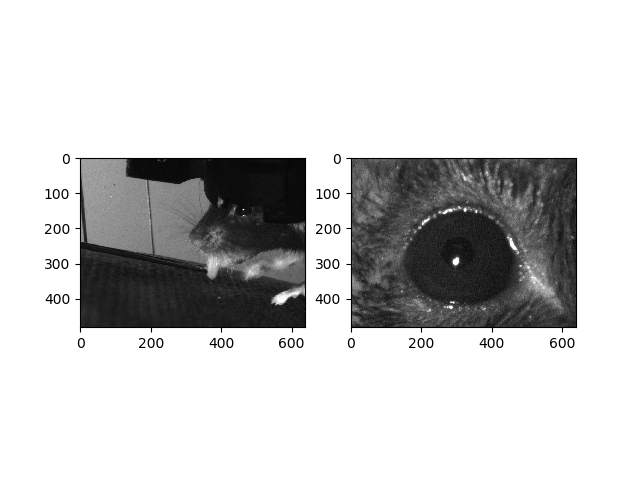

loading the frame from cam1 took 23.291349411010742 milliseconds
loading the frame from cam2 took 21.652936935424805 milliseconds


In [30]:
fig,ax=plt.subplots(1,2)
for ii,cam in enumerate(['cam1','cam2']):
    t0 = time.time()
    frame = movie[cam].get_frame(time=lick_times[230])
    print('loading the frame from {} took {} milliseconds'.format(cam,(time.time()-t0)*1000.))
    ax[ii].imshow(frame)

#### here's an example of using the frame loading method to get each video frame corresponding to a lick, as well as the two frames immediately before and after (assuming a 30 Hz framerate)

<IPython.core.display.Javascript object>


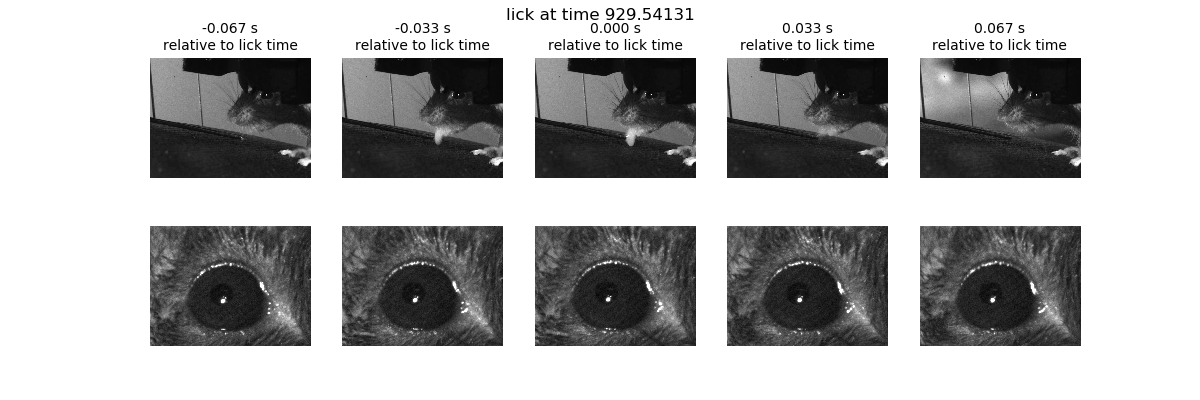

interactive(children=(IntSlider(value=1260, description='lick_number', max=2521), Output()), _dom_classes=('wi…

In [63]:
fig,ax=plt.subplots(2,5,figsize=(12,4))
time_lags = [-2/30.,-1/30.,0,1/30.,2/30.]
for col in range(5):
    ax[0][col].set_title('{:0.3f} s\nrelative to lick time'.format(time_lags[col]),fontsize=10)

@interact()
def plot(lick_number=(0,len(lick_times))):
    for row,cam in enumerate(['cam1','cam2']):
        for col,time_diff in enumerate(time_lags):
            frame = movie[cam].get_frame(time=lick_times[lick_number]+time_diff)
            ax[row][col].imshow(frame)
            ax[row][col].axis('off')
    fig.suptitle('lick at time {}'.format(lick_times[lick_number]))

#### and if we had a particular frame number we were interested in, we can access it directly (instead of referencing by time):

In [66]:
frame_of_interest = 10000

frame = movie['cam1'].get_frame(frame=frame_of_interest)

fig,ax=plt.subplots(1,1)
ax.imshow(frame)

<IPython.core.display.Javascript object>

## Note that we can also turn off lazy mode, which will load the movies into memory. This will save the disk retrieval time for every frame load. However, the initial load time is much slower and memory use is higher

In [62]:
movie_in_memory = {}
for movie_path in movie_paths:
    cam_index = int(movie_path.split('.avi')[0][-1]) + 1 # add 1: camera names are 1-indexed, movie names are 0-indexed
    camera_name = 'cam{}'.format(cam_index)
    t0=time.time()
    movie_in_memory[camera_name] = Movie(movie_path, sync_timestamps=camera_times[camera_name],lazy_load=False)
    print('movie from {} took {} seconds to load'.format(camera_name,time.time()-t0))
print('movie keys: {}'.format(movie.keys()))

movie from cam2 took 130.31597995758057 seconds to load
movie from cam1 took 127.5613100528717 seconds to load
movie keys: dict_keys(['cam2', 'cam1'])


#### note that frame loading is now an order of magnitude faster:

<IPython.core.display.Javascript object>


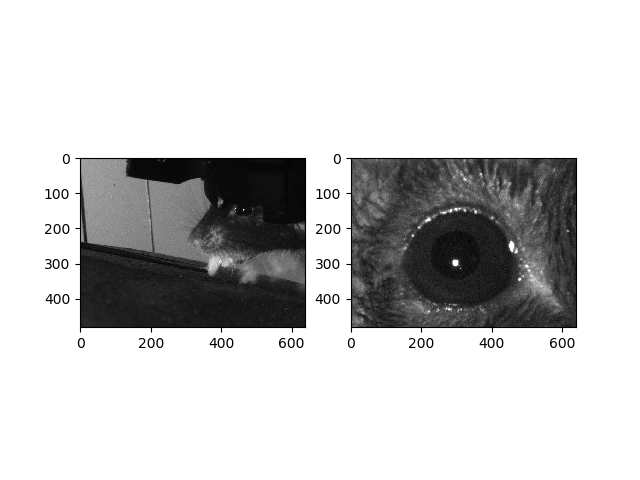

loading the frame from cam1 took 2.3572444915771484 milliseconds
loading the frame from cam2 took 1.5261173248291016 milliseconds


In [59]:
fig,ax=plt.subplots(1,2)
for ii,cam in enumerate(['cam1','cam2']):
    t0 = time.time()
    frame = movie_in_memory[cam].get_frame(time=lick_times[2])
    print('loading the frame from {} took {} milliseconds'.format(cam,(time.time()-t0)*1000.))
    ax[ii].imshow(frame, cmap='gray')